# สร้างข้อมูล sounding จาก ERA5 hourly 
* เนื่องจากวันที่เกิดเหตุการณ์พายุลูกเห็บที่เชียงของ ไม่มีข้อมูลตรวจอกาาศช้นบน จากสถานีเชียงใหม่ จึงต้องใช้ข้อมูลจากแบบจำลอง era 5 hourly โดยดูวิธีการและโค้ดจาก https://www.youtube.com/watch?v=C3YwOG8btMk เพื่อที่จะนำไปพลอตใน sharppy
* เชียงรายไม่มีการตรวจวัดสภาพอากาศชั้นบน มีแต่เชียงใหม่ แต่ก็ไม่ได้มีทุกวัน ให้ดูรายชื่อรหัสสถานีตรวจอากาศจากรายงาน wmo ได้ที่ลิงก์  https://library.wmo.int/doc_num.php?explnum_id=9896
* พิกัดภูมิศาสตร์ใช้บริเวณหาดไคร้ ต.เวียง อ.เชียงของ จังหวัดเชียงราย ได้มาจากกุเกิ้ล https://www.google.com/maps/place/Chiang+Khong+District,+Chiang+Rai/@20.2561247,100.4107162,2644m/data=!3m1!1e3!4m5!3m4!1s0x30d6372562c471b5:0x30346c5fa8a7370!8m2!3d20.1651266!4d100.3947116
* ลงโปรแกรม sharppy binary https://github.com/skovic/SHARPpy/releases/tag/v1.4.0-fixed
* ข้อมูล ERA5 hourly https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-pressure-levels?tab=overview


## ดาวน์โหลดข้อมูล era5 hourly วันที่ 23/04/2020 เวลา 0000UTC
* เนื่องจากอยากวิเคราะห์เวลา 1800 Local time เมื่อ - 7UTC เท่ากับ 1100  แต่ในที่นี้ใช้ 00 UTC เนื่องจากเป็นเวลาที่มีการปล่อยบอลลูนหยั่งอากาศของประเทศไทย ต้องการนำไปเทียบกับเวลา 11 UTC ของวันที่ 23 เมษายน 2020 ต่อไป ว่าผลของเวลาไหนจะได้ค่าดี
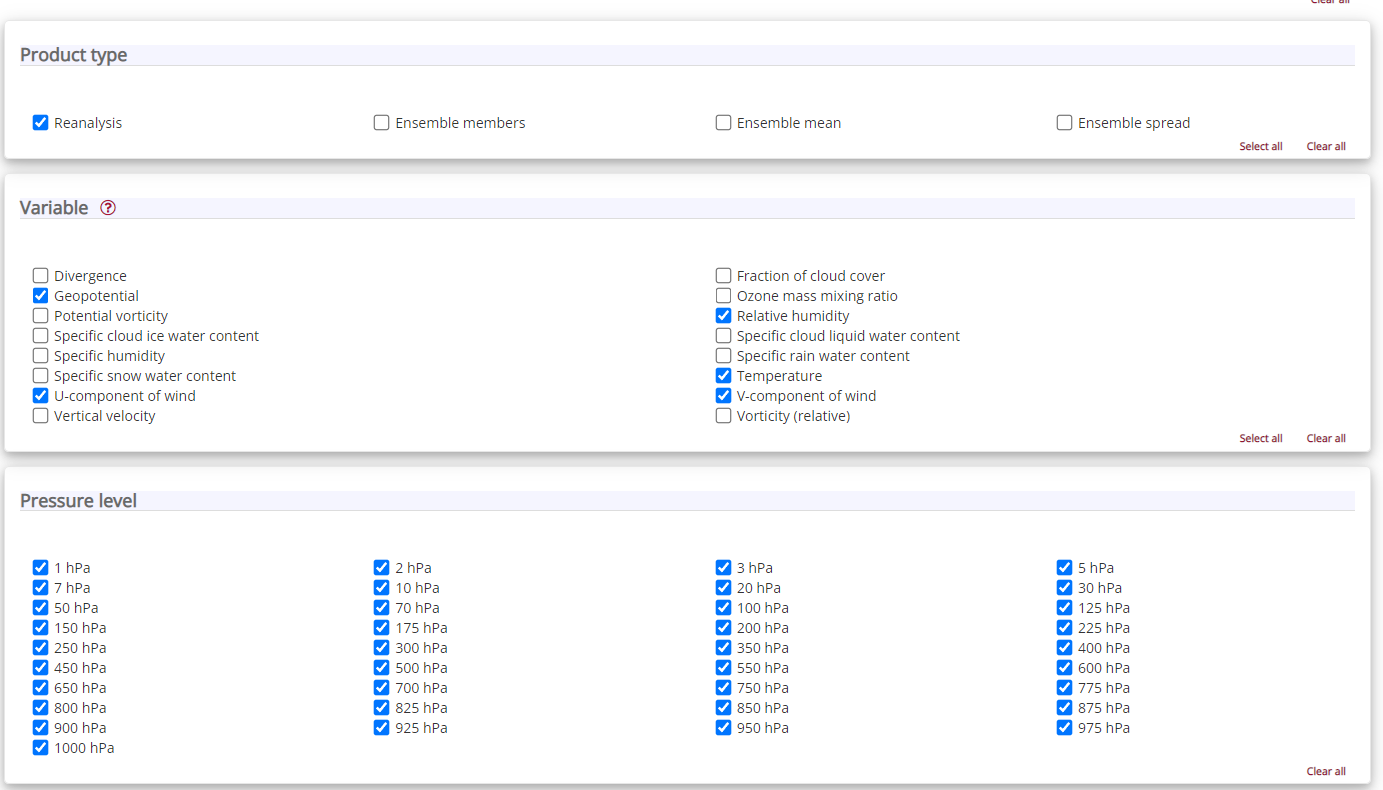

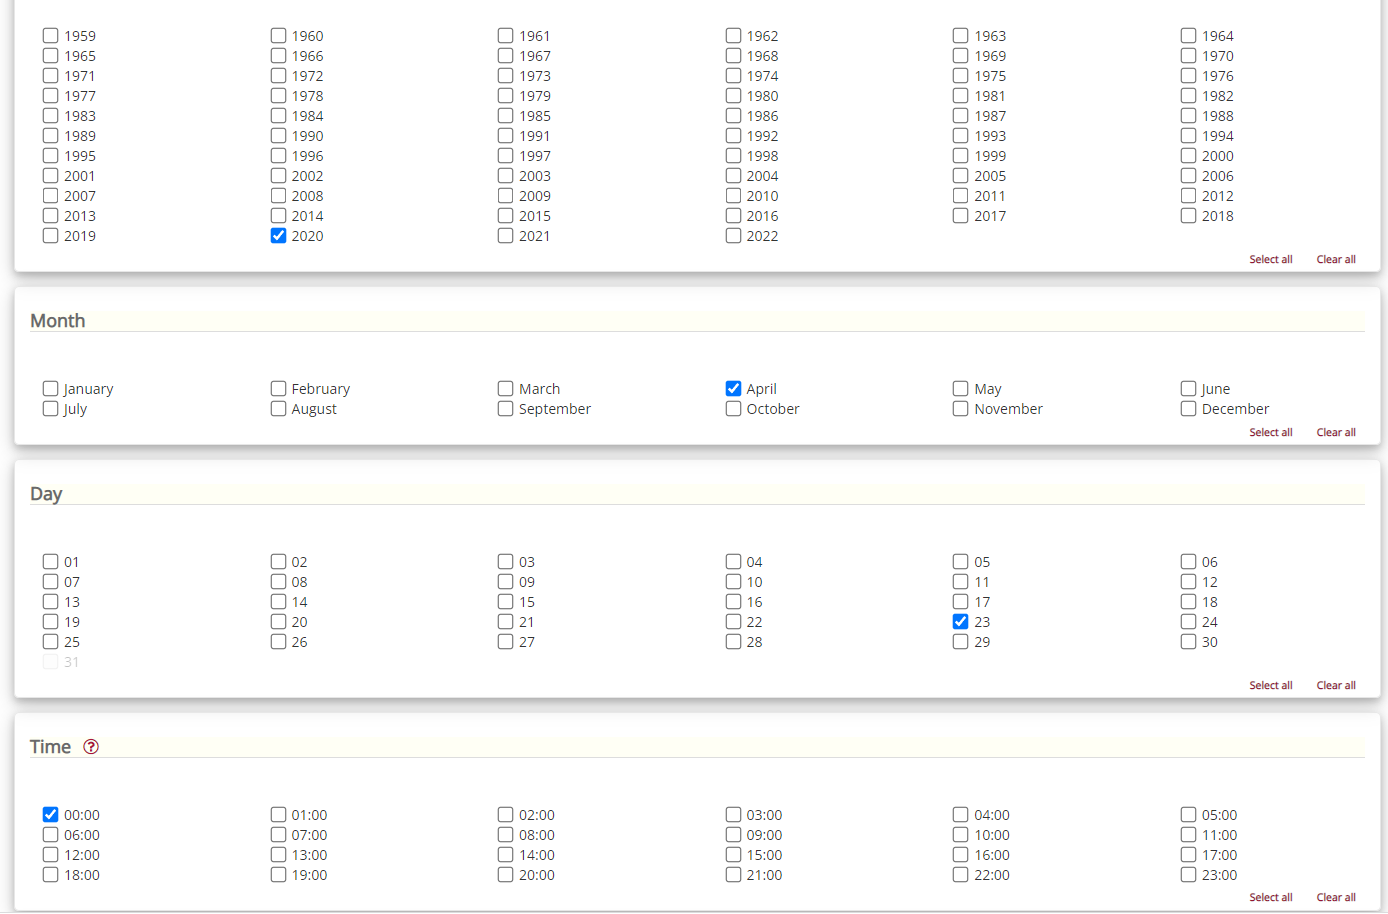

* ใช้ค่าพิกัดต.เวียง อ.เชียงของ จ.เชียงราย  ที่ได้จากกุเกิ้ล
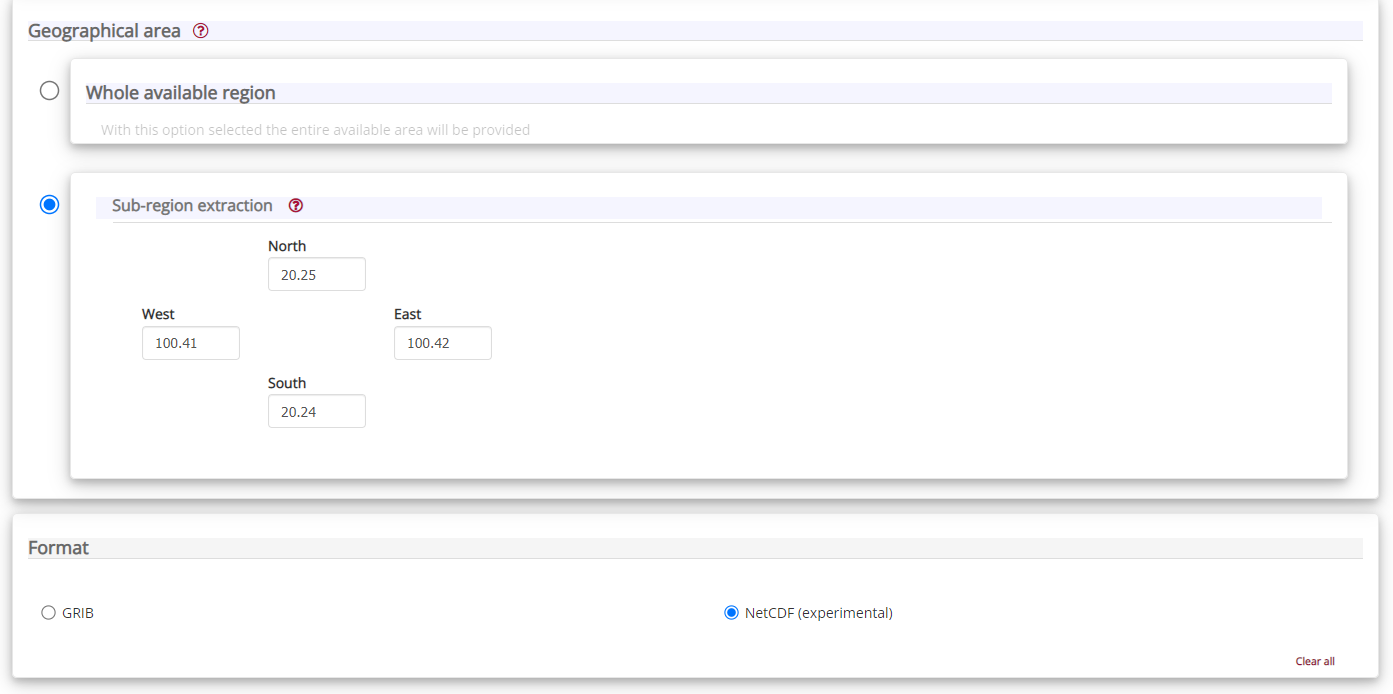


## โค้ดสกัดค่า reanalysis ตามพิกัดที่ต้องการ

In [1]:
from netCDF4 import Dataset
from metpy import calc
from metpy.units import units
import numpy as np

In [2]:
from metpy.calc import equivalent_potential_temperature

# ต้องการคำนวณค่า 3 คอลัมน์สุดท้าย เพื่อให้ได้ตามฟอร์แมท wyoming
ตามลิงก์นี้ https://weather.uwyo.edu/upperair/columns.html
* THTA:	Potential Temperature	[kelvin]
* THTE:	Equivalent Potential Temperature	[kelvin]
* THTV:	Virtual Potential Temperature	[kelvin]

แต่ยังมีค่าที่เรายังไม่มีอีก ต้องหาทางคำนวณ หรือ ดาวน์โหลดค่ามา
* FRPT:	Frost Point Temperature	[celsius]
* RELI:	Relative Humidity with respect to Ice	[%]
* MIXR:	Mixing Ratio	[gram/kilogram]

## อ่านค่าแบบจำลองที่สกัดมาได้

In [3]:
ds = Dataset('./1data/chiangkong_23042020_00UTC.nc')
lat = ds['latitude'][:]
lon = ds['longitude'][:]

## หาตำแหน่งที่ใกล้กับตำแหน่งที่ต้องการของหาดไคร้

In [4]:
c_x, c_y = 20.255734, 100.410341
x, y = np.abs(lat - c_x).argmin(), np.abs(lon + c_y).argmin()

## คำนวณค่าตัวแปรอุตุ

In [5]:
levels = ds['level'][:]
z = ds['z'][0, :, y, x] / 9.81
u = ds['u'][0, :, y, x]
v = ds['v'][0, :, y, x]
temp = ds['t'][0, :, y, x] - 273.15
rh = ds['r'][0, :, y, x]

## 	Dewpoint Temperature

In [6]:
DWPT = np.asarray(calc.dewpoint_from_relative_humidity(np.asarray(temp) * units.degC, np.asarray(rh) * units.percent))
DWPT

array([-1.06245483e+02, -1.05473444e+02, -9.96701726e+01, -9.83491695e+01,
       -9.70585165e+01, -9.52232343e+01, -9.10576205e+01, -8.88617850e+01,
       -8.60159659e+01, -8.38781556e+01, -8.15304131e+01, -7.86551648e+01,
       -7.33634529e+01, -6.55918860e+01, -5.41724100e+01, -4.82589863e+01,
       -4.38631637e+01, -3.97675882e+01, -3.40110615e+01, -2.78117370e+01,
       -2.45053809e+01, -1.60841260e+01, -1.04780232e+01, -8.16895047e+00,
       -1.37972395e-02,  4.83646053e+00,  6.58576626e+00,  6.98494111e+00,
        8.04346943e+00,  9.92308389e+00,  1.26211422e+01,  1.50304678e+01,
        1.55550564e+01,  1.54198725e+01,  1.89941823e+01,  2.18543274e+01,
        2.32721538e+01])

## Wind Direction

In [7]:
DRCT = np.degrees(np.arctan2(u ,v)) + 180
DRCT

masked_array(data=[268.2211001968065, 282.47888033271295,
                   260.208223357628, 174.80658716991812,
                   122.93243779513841, 231.09171246241615,
                   85.94013316279913, 97.27648210609517,
                   28.867444125759874, 278.6461052149145,
                   251.44163941138055, 254.68623637696876,
                   233.87531526822823, 228.51869222295815,
                   227.44940182705105, 223.2273137339253,
                   229.67526712516923, 235.00741342902927,
                   245.76755583791163, 252.02001867356415,
                   256.88650326308425, 261.52319600158035,
                   261.1909187738894, 255.22749975286104,
                   240.25238026908931, 243.7740910048941,
                   262.01841910836737, 259.02747719109436,
                   245.92361322526062, 226.86125080341282,
                   210.14147868281543, 194.14374816820074,
                   179.7522328057951, 162.1263876277094,
        

## Wind Speed

In [8]:
wspd = np.hypot(u, v) * 1.944
wspd #หน่วยยังเป็น m/s  อ่านเอกสารของ ERA5 ที่ https://apps.ecmwf.int/codes/grib/param-db/?id=131


masked_array(data=[ 6.87758988, 27.33217998, 31.43401937,  5.86601141,
                    6.22448238,  2.70750671, 28.36226393, 23.06218512,
                   10.76357192, 14.15048342, 37.09122865, 46.12870065,
                   54.28949922, 67.69895562, 79.33566215, 77.18505809,
                   71.78032483, 52.8494912 , 46.65476678, 43.1836753 ,
                   38.8219586 , 39.38604214, 33.409785  , 28.37757185,
                   21.85715351, 13.6164953 , 10.84676002, 11.47694865,
                   12.77999836, 15.94139096, 19.1488504 , 17.61886826,
                   11.9915323 ,  6.08554204,  1.58246221,  0.94563613,
                    0.90956885],
             mask=False,
       fill_value=1e+20)

### แปลง หน่วยจาก m/s ไปเป็น knot ตามฟอร์แมทของ wyoming https://weather.uwyo.edu/upperair/columns.html

In [9]:
SKNT = (np.asarray(wspd) * units('m/s')).to(units.knot)
SKNT = np.asarray(SKNT) 

# Relative Humidity

In [10]:
RELH = np.asarray(rh) * units.percent
RELH = np.asarray(RELH) 
RELH

array([3.18315811e-04, 3.18315811e-04, 1.93377183e-03, 1.16265079e-02,
       2.29347000e-02, 4.55510842e-02, 2.86254030e-01, 7.88660851e-01,
       3.05353018e+00, 2.67781172e+01, 5.68078291e+01, 2.69638947e+01,
       2.46812553e+01, 4.14416115e+01, 1.05865997e+02, 9.97886518e+01,
       9.16435226e+01, 5.58999428e+01, 4.16839299e+01, 4.00846284e+01,
       3.49200155e+01, 5.24477133e+01, 6.07301563e+01, 5.06432489e+01,
       6.95877016e+01, 7.46311553e+01, 6.20774466e+01, 5.49775174e+01,
       5.21860094e+01, 5.35122988e+01, 5.93925587e+01, 6.50999648e+01,
       6.23472277e+01, 5.50712139e+01, 6.50805793e+01, 6.90982184e+01,
       6.92371476e+01])

# ข้อสังเกต ความชื้นสัมพัทธ์ ต่ำมาก ๆ 

# Potential Temperature
คำนวณจากวิธี https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.potential_temperature.html#examples-using-metpy-calc-potential-temperature

In [11]:
# แปลงหน่วยอุณหภูมิเพื่อคำนวณค่า PT
T_k = ((np.asarray(temp)) + 273.15) * units.kelvin

In [12]:
THTA = calc.potential_temperature(np.asarray(levels) * units.hPa, np.asarray(T_k) *  units.kelvin) 
THTA = np.asarray(THTA) 

# Equivalent Potential Temperature
ใช้วิธีในการคำนวณจาก https://unidata.github.io/MetPy/dev/examples/calculations/Equivalent_Potential_Temperature.html

In [13]:
THTE = calc.equivalent_potential_temperature(np.asarray(levels) * units.hPa, np.asarray(temp) * units.degC, np.asarray(DWPT) * units.degC)
THTE = np.asarray(THTE) 

# Virtual Potential Temperature
* คำนวณค่า mixing ratio ก่อน ด้วยการใช้ pressure, temperature และ relative humidity จากลิงก์ https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.mixing_ratio_from_relative_humidity.html
* คำนวณค่า Virtual Potential Temperature จากลิงก์ https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.virtual_potential_temperature.html

## หา mixing ratio

In [14]:
MIXR = calc.mixing_ratio_from_relative_humidity(np.asarray(levels) * units.hPa, np.asarray(temp) * units.degC, np.asarray(rh) * units.percent) * units('g/kg')
MIXR = np.asarray(MIXR) *1000.0 # เอา 1000 ไปคูณจะกลายเป็นหน่วยกรัม

## หา Virtual Potential Temperature

In [15]:
THTV = calc.virtual_potential_temperature(np.asarray(levels) * units.hPa, np.asarray(temp) * units.degC, np.asarray(MIXR)  * units('g/kg'))
THTV = np.asarray(THTV)

## บันทึกข้อมูล sounding ให้อยู่ในฟอร์แมทของ wyomming

In [16]:
with open('./2output/era5_23042020_0000utc_wyoming.txt', 'w', encoding = 'utf-8') as f:
    f.write(f"48303 VTCC Chiang Rai ERA5 Simulated at 00z 23 Apr 2020\n\n")
    f.write(f"-----------------------------------------------------------------------------\n")
    f.write(f"   PRES   HGHT   TEMP   DWPT   RELH   MIXR   DRCT   SKNT   THTA   THTE   THTV\n")
    f.write(f"    hPa     m      C      C      %    g/kg    deg   knot     K      K      K \n")
    f.write(f"-----------------------------------------------------------------------------\n")
    

    for i in reversed(range(len(levels))):
        f.write(f"{levels[i]:>7.1f}{z[i]:>7.0f}{temp[i]:7.2f}{DWPT[i]:7.2f}{rh[i]:7.0f}{MIXR[i]:7.2f}{DRCT[i]:7.0f}{SKNT[i]:7.0f}{THTA[i]:7.1f}{THTE[i]:7.1f}{THTV[i]:7.1f}\n") #ok
        #f.write("%.1f\n" %levels[i]) #ok
        #f.write(f"{levels[i]:.1f}\t{z[i]:5.1f}\t{temp[i]:3.1f}\t{DWPT[i]:3.1f}\t{rh[i]:3.1f}\t{MIXR[i]:3.4f}\t{DRCT[i]:3.1f}\t{SKNT[i]:3.1f}\t{THTA[i]:4.1f}\t{THTE[i]:4.1f}\t{THTV[i]:4.1f}\t\n")

    f.write('Station information and sounding indices')
    

## ต้องใช้ฟอร์แมทด้านล่าง กำหนด spcae จำนวนตัวเลขก่อนและหลังทศนิยม หรือ จำนวนเต็ม
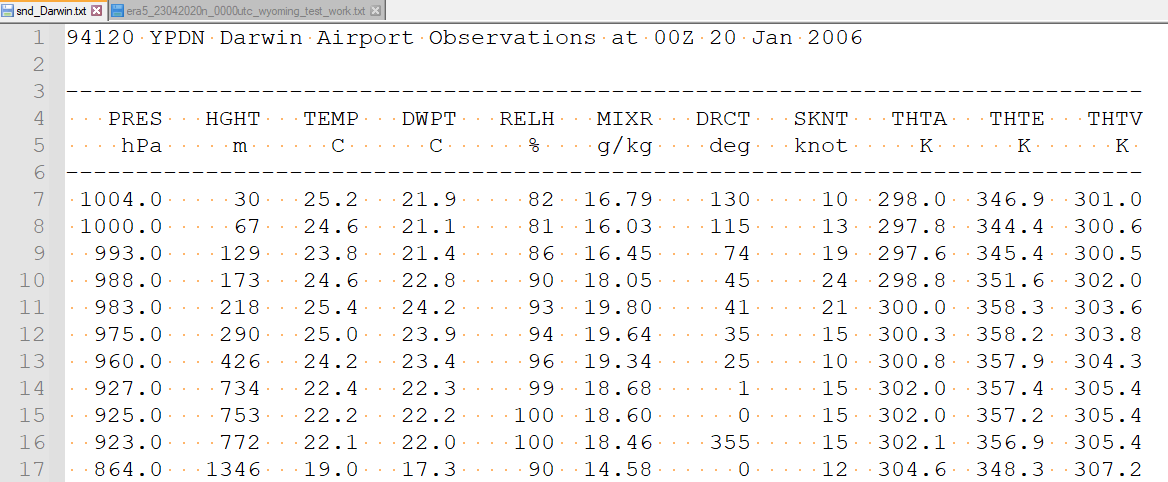